# Miniproject 3: Poem Generation

### Download Data

In [28]:
import requests

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


### Importing packages \& Preprocessing

In [1]:
%load_ext autoreload
%autoreload now
# import Sonnet class and unsupervised_HMM function
from Sonnet import Sonnet  # noqa: E402
# from HMM_function import HiddenMarkovModel as HMM
import HMM_function as HMM  # noqa: E402

from syllable_reader_2 import syllable_read



# process data (Shakespeare)
snShakespeare = Sonnet(filename="shakespeare.txt",sequenceType="Stanza")
snShakespeare.read()
snShakespeare.buildSequenceStr()
print(snShakespeare)
snShakespeare.parse_observations()
snShakespeare.obs_map_reverser()

# process data (Spenser)
snSpenser = Sonnet(filename="spenser.txt",sequenceType="Stanza")
snSpenser.read()
snSpenser.buildSequenceStr()
snSpenser.parse_observations()
snSpenser.obs_map_reverser()

# process data (Syllables)
syllables = syllable_read('syllable_dict.txt') 



# Implementing Models

## HMM Code

In [30]:
print(snShakespeare.obs)
HMM1 = HMM.unsupervised_HMM(snShakespeare.obs, n_states = 4, N_iters = 10, seed = 123)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 10, 24, 21, 25], [13, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 34, 46, 34, 47, 28, 34, 48, 46, 49, 50], [26, 6, 51, 52, 15, 53, 54, 55, 56, 57, 58, 28, 15, 59, 60, 61, 29, 30, 62, 63, 34, 64, 56, 22, 65, 66, 67, 68, 69], [70, 15, 71, 72, 73, 74, 75, 76, 28, 77, 15, 53, 78, 18, 15, 79, 56, 80], [81, 82, 83, 84, 85, 34, 86, 56, 87, 88, 89, 68, 34, 8, 90, 34, 91, 92, 93, 94, 95, 96, 52, 97, 76, 41, 98, 99, 100, 101, 102, 103], [104, 105, 106, 43, 107, 34, 108, 45, 43, 107, 15, 109, 100, 34, 110, 111, 28, 112, 61, 29, 30, 88, 113, 32, 114, 115, 116, 117, 56, 118, 119], [120, 121, 122, 119, 123, 34, 8, 124, 125, 26, 126, 127, 74, 128, 129, 100, 130, 84, 131, 132, 133, 56, 134, 132, 135, 136, 137, 21, 108, 18, 138, 29], [74, 114, 28, 76, 139, 140, 81, 26, 51, 135, 56, 141, 34, 142, 143, 81, 26, 144, 145, 146], [147, 68, 34, 148, 56, 149, 15, 150, 26, 151, 52, 152, 15

In [31]:
HMM.sample_sentence(HMM1, snShakespeare.obs_map_r, syllables, n_words=10)

14


'Injury are sickness their bad nothing makes in my thine'

## RNN Code

In [1]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('shakespeare.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)

# categories: 1 ['shakespeare']


In [2]:
training_lines = list(filter(lambda x: len(x) > 0, category_lines['shakespeare']))
#for i in range(len(training_lines)):
#    training_lines[i] = (filter(lambda x: x != ',', category_lines['shakespeare'][i]))

In [3]:
import RNN
import torch
import torch.nn as nn

n_input = 128
RNN_obj = RNN.RNN(n_input, 128, n_letters)

In [4]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingLines():
    line = randomChoice(training_lines)
    return line

In [5]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)


In [6]:
line = randomTrainingLines()
print(line)
print(n_letters)
ipt = inputTensor(line)
opt = targetTensor(line)

To critic and to flatterer stopped are
59


In [7]:
def randomTrainingExample():
    line = randomTrainingLines()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

In [11]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005

def train(rnn, input_line_tensor, target_line_tensor):
    #target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden(len(input_line_tensor))

    #hidden.unsqueeze_(-1)

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    #for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(input_line_tensor, hidden)
    
    l = criterion(output, target_line_tensor)
    loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [12]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
rnn = RNN.RNN(n_letters, 128, n_letters)

print(n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

59
0m 2s (5000 5%) 0.0969
0m 5s (10000 10%) 0.0827
0m 7s (15000 15%) 0.0944
0m 10s (20000 20%) 0.1013
0m 12s (25000 25%) 0.1123
0m 15s (30000 30%) 0.0979
0m 17s (35000 35%) 0.0917
0m 20s (40000 40%) 0.1002
0m 22s (45000 45%) 0.0868
0m 25s (50000 50%) 0.0855
0m 27s (55000 55%) 0.0877
0m 30s (60000 60%) 0.0730
0m 32s (65000 65%) 0.1121
0m 35s (70000 70%) 0.0992
0m 37s (75000 75%) 0.0885
0m 40s (80000 80%) 0.0854
0m 42s (85000 85%) 0.0893
0m 45s (90000 90%) 0.1065
0m 47s (95000 95%) 0.0988
0m 50s (100000 100%) 0.1012


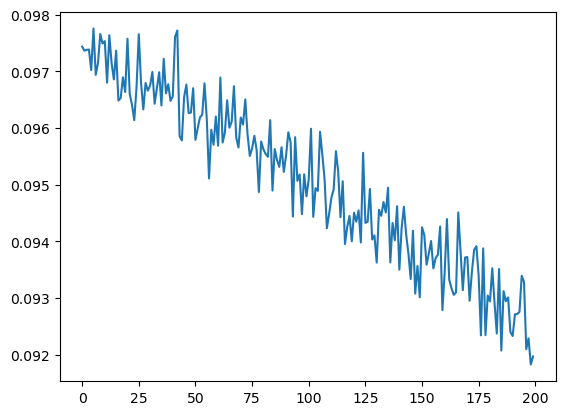

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Additional Goal

## Visualization